# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib14'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib14.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib14/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib14/pear_merged-fullCyc2_lib14.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib14.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 14800225
Number of sequences post-filter: 14756127

>CC.M.151027.H2O-Con.D14_1 orig_name=M01032:505:000000000-B45R5:1:1101:15732:1332
TACGTAGGGGACAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCGCGTAGGCGTACAGACAGGTCAGCTGTGAAAACTC
GAGGCTCAACCTCGAGACGTCGGTTGAAACCGTCTGGCTAGAGTCCGGAAGAGGAGAGTGGAATTCCCGGTGTAGCGGTG
AAATGCGTAGATATTGGGAGGAACACCGGTGGCGAAGGCGGCCCCCTGGACCGGTACTGACGCTGATGCGCGAAAGCGTG
GGGAGCAAACGGG
>MR.A.151027.12C-Van.D04_2 orig_name=M01032:505:000000000-B45R5:1:1101:15967:1333
TACGAGGGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGCGGTAAGTCACCTGTGAAACCTC
TAGGCTTAACCTAGAGCGTGCAGGCGAAACTGCCGTGCTTGAGGGTGGGAGAGGTGCGTGGAATTCCCGGTGTAGCGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 14756127
Number of sequences post-filter: 14756127


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

CC.M.151027.H2O-Con.D14_1	CC.M.151027.H2O-Con.D14
MR.A.151027.12C-Van.D04_2	MR.A.151027.12C-Van.D04
CC.M.151027.12C-Van.D04_3	CC.M.151027.12C-Van.D04
BH.A.151026.12C-Xyl.D02_4	BH.A.151026.12C-Xyl.D02
CC.F.151027.12C-Ami.D02_5	CC.F.151027.12C-Ami.D02
MR.F.151027.H2O-Con.D28_0	MR.F.151027.H2O-Con.D28
EL.M.151026.H2O-Con.D14_6	EL.M.151026.H2O-Con.D14
SS.M.151026.12C-Cel.D28_7	SS.M.151026.12C-Cel.D28
EL.M.151026.H2O-Con.D02_8	EL.M.151026.H2O-Con.D02
EL.M.151026.H2O-Con.D02_9	EL.M.151026.H2O-Con.D02


In [13]:
! head -n 200 group_file.txt

CC.M.151027.H2O-Con.D14_1	CC.M.151027.H2O-Con.D14
MR.A.151027.12C-Van.D04_2	MR.A.151027.12C-Van.D04
CC.M.151027.12C-Van.D04_3	CC.M.151027.12C-Van.D04
BH.A.151026.12C-Xyl.D02_4	BH.A.151026.12C-Xyl.D02
CC.F.151027.12C-Ami.D02_5	CC.F.151027.12C-Ami.D02
MR.F.151027.H2O-Con.D28_0	MR.F.151027.H2O-Con.D28
EL.M.151026.H2O-Con.D14_6	EL.M.151026.H2O-Con.D14
SS.M.151026.12C-Cel.D28_7	SS.M.151026.12C-Cel.D28
EL.M.151026.H2O-Con.D02_8	EL.M.151026.H2O-Con.D02
EL.M.151026.H2O-Con.D02_9	EL.M.151026.H2O-Con.D02
SS.F.151026.H2O-Con.D02_10	SS.F.151026.H2O-Con.D02
CC.F.151027.H2O-Con.D14_11	CC.F.151027.H2O-Con.D14
MR.A.151027.12C-Van.D04_12	MR.A.151027.12C-Van.D04
MR.A.13C-Xyl.D6.R1_Frac17_13	MR.A.13C-Xyl.D6.R1_Frac17
BH.F.151026.12C-Xyl.D02_14	BH.F.151026.12C-Xyl.D02
CF.M.151027.12C-Ami.D04_15	CF.M.151027.12C-Ami.D04
CF.A.151027.H2O-Con.D14_16	CF.A.151027.H2O-Con.D14
MF.A.151026.12C-Cel.D14_17	MF.A.151026.12C-Cel.D14
MF.F.151026.12C-Xyl.D02_18	MF.F.151026.12C-Xyl.D02
CC.F.151027.H2O-Con.D14_19	CC.F.15102

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

14735000	6268961
14736000	6269335
14737000	6269740
14738000	6270147
14739000	6270559
14740000	6270967
14741000	6271350
14742000	6271759
14743000	6272165
14744000	6272563
14745000	6272994
14746000	6273407
14747000	6273799
14748000	6274207
14749000	6274613
14750000	6275028
14751000	6275442
14752000	6275837
14753000	6276278
14754000	6276690
14755000	6277122
14756000	6277546
14756127	6277607

Output File Names: 
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 6277607


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 654M May 16 16:32 pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-16 16:32:24--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.88M 10s
    50K .......... .......... .......... .......... ..........  0%  996K 15s
   100K .......... .......... .......... .......... ..........  0% 1.88M 13s
   150K .......... .......... .......... .......... ..........  1%  989K 14s
   200K .......... .......... .......... .......... ..........  1% 1.89M 14s
   250K .......... .......... .......... .......... ..........  1%  990K 14s
   300K .......... .......... .......... .......... ..........  1% 1.87M 14s
   350K .......... .......... .......... .......... ..........  2%  993K 14s
   400K .......... .......... .......

In [ ]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [ ]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

In [ ]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

In [ ]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

In [ ]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

In [26]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	465	1471	253	0	4	368904
25%-tile:	465	1471	253	0	4	3689032
Median: 	465	1471	253	0	5	7378064
75%-tile:	465	1471	253	0	5	11067096
97.5%-tile:	465	1471	254	0	8	14387224
Maximum:	2054	2054	412	0	43	14756127
Mean:	466.193	1471.24	252.791	0	4.86608
# of unique seqs:	6277607
total # of seqs:	14756127

Output File Names: 
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.unique.filter.summary

It took 46 secs to summarize 14756127 sequences.

mothur > quit()


In [25]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | cat > mothursummary.txt

^C


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [27]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 465, 1471)
!$cmd | tail -n 30

Processing sequence: 312300
Processing sequence: 312400
Processing sequence: 312500
Processing sequence: 312600
Processing sequence: 312700
Processing sequence: 312800
Processing sequence: 312900
Processing sequence: 313000
Processing sequence: 313100
Processing sequence: 313200
Processing sequence: 313300
Processing sequence: 313400
Processing sequence: 313500
Processing sequence: 313600
Processing sequence: 313700
Processing sequence: 313800
Processing sequence: 313900
Processing sequence: 314000
Processing sequence: 314095

Output File Names: 
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 116 secs to screen 6277607 sequences.

mothur > quit()


In [28]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 6161203


In [ ]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

307800
307900
308000
308100
308200
308271



Length of filtered alignment: 1262
Number of columns removed: 792
Length of the original alignment: 2054
Number of sequences used to construct filter: 6161203

Output File Names: 
pear_merged-fullCyc2_lib14.filter
pear_merged-fullCyc2_lib14.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [ ]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

## Deunique seqs

In [ ]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

### Final QC-ed file

In [ ]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [43]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	204	204	0	3	1
2.5%-tile:	1	253	253	0	4	362585
25%-tile:	1	253	253	0	4	3625841
Median: 	1	253	253	0	5	7251681
75%-tile:	1	253	253	0	5	10877521
97.5%-tile:	1	254	254	0	8	14140777
Maximum:	1	412	412	0	8	14503360
Mean:	1	253.038	253.038	0	4.85272
# of Seqs:	14503360

Output File Names: 
finalQC.summary

It took 14 secs to summarize 14503360 sequences.

mothur > quit()


In [41]:
!head -n 6 $qcFinal

>CC.M.151027.H2O-Con.D14_1
TACGTAGGGGACAAGCGTTGTCCGGATTTATTGGGCGTAAAGAGCGCGTAGGCGTACAGACAGGTCAGCTGTGAAAACTCGAGGCTCAACCTCGAGACGTCGGTTGAAACCGTCTGGCTAGAGTCCGGAAGAGGAGAGTGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATTGGGAGGAACACCGGTGGCGAAGGCGGCCCCCTGGACCGGTACTGACGCTGATGCGCGAAAGCGTGGGGAGCAAACGGG
>MR.A.151027.12C-Van.D04_2
TACGAGGGGGGCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGTGCGGTAAGTCACCTGTGAAACCTCTAGGCTTAACCTAGAGCGTGCAGGCGAAACTGCCGTGCTTGAGGGTGGGAGAGGTGCGTGGAATTCCCGGTGTAGCGGTGAAATGCGTAGATATCGGGAGGAACACCAGTGGCGAAGGCGATGATCTGGGGCTAACCTGACACTGAGGAGCGAAAGCTAGGGGAGCAAACGGG
>CC.M.151027.12C-Van.D04_3
TACGTAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGCTTGTCGCGTCGGCTGTGAAAACCTGGGGCTCAACCCCGGGCCTGCAGCCGATACGGGCAAGCTAGAATTCGGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGAGCCGAAATTGACGCTGAGGAGCGAAAGCGTGGGGAGCAAACAGG


## Summary of number of seqs per sample

In [ ]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [ ]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

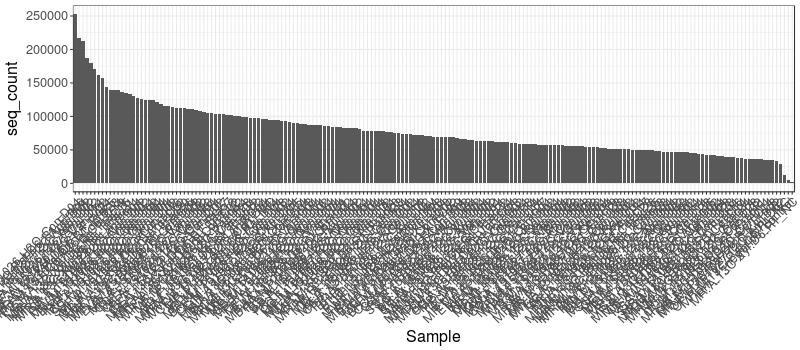

In [40]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [42]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 20000,]

                    Sample seq_count rank
183  MR.M.13C-Pal.D6.R1_NC     11898    3
184 Enr_1_negative_control      4275    2
185  MR.A.13C-Xyl.D6.R1_NC      2055    1
